In [2]:
# Plotting
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

import warnings; 
warnings.simplefilter('ignore')

from datetime import datetime
import pandas as pd
import numpy as np

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Deep Learing
import keras
import itertools
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, GRU
from keras.utils import to_categorical
from keras.optimizers import Adam 
from keras.callbacks import History, TerminateOnNaN, ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
from keras import backend as K

plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [3]:
df = pd.read_csv("data_v2.csv")

In [4]:
df.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
0,MAC000002,Std,2013-01-01 00:00:00,0.219,ACORN-A,Affluent
1,MAC000002,Std,2013-01-01 00:30:00,0.241,ACORN-A,Affluent
2,MAC000002,Std,2013-01-01 01:00:00,0.191,ACORN-A,Affluent
3,MAC000002,Std,2013-01-01 01:30:00,0.235,ACORN-A,Affluent
4,MAC000002,Std,2013-01-01 02:00:00,0.182,ACORN-A,Affluent


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45858295 entries, 0 to 45858294
Data columns (total 6 columns):
LCLid                      object
stdorToU                   object
DateTime                   object
KWH/hh (per half hour)     float64
Acorn                      object
Acorn_grouped              object
dtypes: float64(1), object(5)
memory usage: 2.1+ GB


In [6]:
df = df.rename({'KWH/hh (per half hour) ': 'KWh'}, axis=1)

In [7]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [8]:
feature_date_time = df.groupby('DateTime')['KWh'].agg(['mean'])

In [9]:
feature_date_time.head()

,mean
DateTime,
2013-01-01 00:00:00,0.240512
2013-01-01 00:30:00,0.221784
2013-01-01 01:00:00,0.204738
2013-01-01 01:30:00,0.187682
2013-01-01 02:00:00,0.170383


In [10]:
feature_date_time = feature_date_time.rename(columns={'mean':'Avg_KWh'})

In [11]:
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'Avg_KWh'}
date_train =  datetime.strptime('2013-10-02 23:30:00', '%Y-%m-%d %H:%M:%S')

In [12]:
df_train = feature_date_time[feature_date_time.index <= date_train]
df_test = feature_date_time[feature_date_time.index > date_train]

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13200 entries, 2013-01-01 00:00:00 to 2013-10-02 23:30:00
Data columns (total 1 columns):
Avg_KWh    13200 non-null float64
dtypes: float64(1)
memory usage: 206.2 KB


In [14]:
scaler = 3
(feature_range=(0, 1))

# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])
df_train.describe()

,Avg_KWh
count,13200.000000
mean,0.298474
std,0.191633
min,0.000000
25%,0.161982
50%,0.274207
75%,0.403862
max,1.000000


In [15]:
df_test.describe()

,Avg_KWh
count,4320.000000
mean,0.346908
std,0.208946
min,0.003737
25%,0.183376
50%,0.332011
75%,0.498083
max,0.814432


In [16]:
def create_x_tensors(data, n_in, dropNaN=True):
    """
    Creates X tensors for LSTM time series prediction
    Output has shape (samples, timesteps, features)
    """
    # create lagged variables
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)

    # reshape data to shape [samples, timesteps, features]
    return lagged_df.values.reshape((lagged_df.shape[0], n_in, n_features))


def create_y_tensor(data, n_out=1, dropNaN=True):
    """
    Creates Y tensor for LSTM time series prediction
    """
    dff = pd.DataFrame(data)
    cols = list()
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)

    # reshape data to shape [samples, timesteps]
    return lagged_df.values.reshape((lagged_df.shape[0], n_out))


def prepare_data(data, n_in, n_out, step_foreward):
    df = pd.DataFrame(data)

    # check steps and cut data at the beginning
    timesteps = df.shape[0]
    steps = int((timesteps - n_in - n_out) / step_foreward)
    nDrop = timesteps - (steps * n_out + n_in + n_out)
    if nDrop > 0:
        df = df[nDrop:]
    return df


def create_tensors(data, column_value, n_in=1, n_out=1, step_foreward=1, dropNaN=True):
    n_features = data.shape[1]
    df = pd.DataFrame(data)

    # X tensor
    cols = list()
    dfX = df[column_value][:-n_out]
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)
    # reshape data to shape [samples, timesteps, features]
    tensor_X = lagged_df.values.reshape((lagged_df.shape[0], n_in, n_features))
    tensor_X = tensor_X[range(0, tensor_X.shape[0], step_foreward)]

    # y tensor
    cols = list()
    dfY = df[column_value][n_in:]
    for i in range(0, n_out):
        cols.append(dfY.shift(-i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)
    # reshape data to shape [samples, timesteps]
    tensor_y = lagged_df.values.reshape((lagged_df.shape[0], n_out))
    tensor_y = tensor_y[range(0, tensor_y.shape[0], step_foreward)]

    return tensor_X, tensor_y

In [17]:
train_X, train_y = create_tensors(df_train, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
train_X.shape

(549, 24, 1)

In [18]:
def keras_model(dropout_rate):
    model = Sequential()
    model.add(Dropout(dropout_rate, input_shape=(train_X.shape[1], train_X.shape[2])))
    lstm = LSTM(256, recurrent_dropout=0.3)
    model.add(lstm)
    model.add(Dropout(dropout_rate))
    model.add(Dense(128))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128))
    model.add(Dense(h_params['n_out']))
    return model

In [19]:
model = keras_model(dropout_rate=0.2)
model.compile(loss='mae', optimizer=Adam(), metrics=['accuracy'])

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 24, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [21]:
history = History()
nan_terminator = TerminateOnNaN()
early_stopping = EarlyStopping(patience=10, 
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=50, 
                              verbose=1, 
                              mode='auto', 
                              epsilon=0.0001, 
                              cooldown=0, 
                              min_lr=1e-8)

history = model.fit(train_X, train_y, epochs=500, batch_size=250, validation_split=0.25, verbose=1, shuffle=True,
                    callbacks=[history, nan_terminator, reduce_lr])

Train on 411 samples, validate on 138 samples
Epoch 1/500
411/411 [==============================] - 5s 12ms/step - loss: 0.3064 - acc: 0.0998 - val_loss: 0.1603 - val_acc: 0.1812
Epoch 2/500
411/411 [==============================] - 0s 1ms/step - loss: 0.2206 - acc: 0.1557 - val_loss: 0.1402 - val_acc: 0.1812
Epoch 3/500
411/411 [==============================] - 0s 1ms/step - loss: 0.1935 - acc: 0.1606 - val_loss: 0.1215 - val_acc: 0.1812
Epoch 4/500
411/411 [==============================] - 0s 1ms/step - loss: 0.1684 - acc: 0.1119 - val_loss: 0.1029 - val_acc: 0.1957
Epoch 5/500
411/411 [==============================] - 0s 1ms/step - loss: 0.1617 - acc: 0.1144 - val_loss: 0.0981 - val_acc: 0.0072
Epoch 6/500
411/411 [==============================] - 0s 1ms/step - loss: 0.1511 - acc: 0.0852 - val_loss: 0.0980 - val_acc: 0.0072
Epoch 7/500
411/411 [==============================] - 0s 1ms/step - loss: 0.1423 - acc: 0.0657 - val_loss: 0.0949 - val_acc: 0.0072
Epoch 8/500
411/411 [=

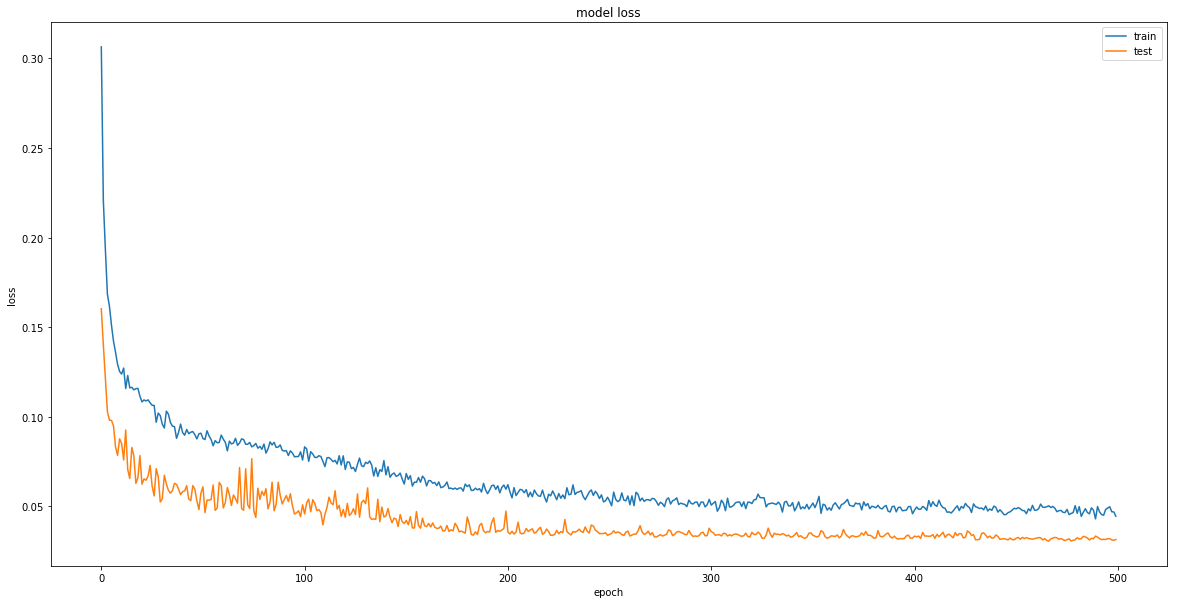

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

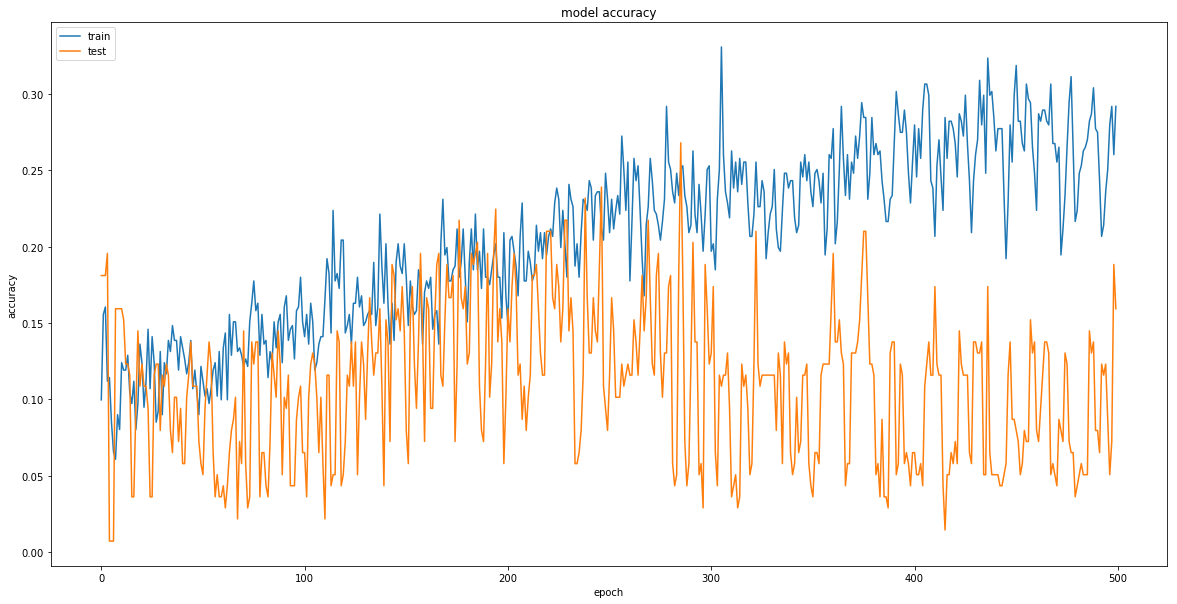

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

In [24]:
test_X, test_y = create_tensors(df_test, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [25]:
test_X.shape

(179, 24, 1)

In [26]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])

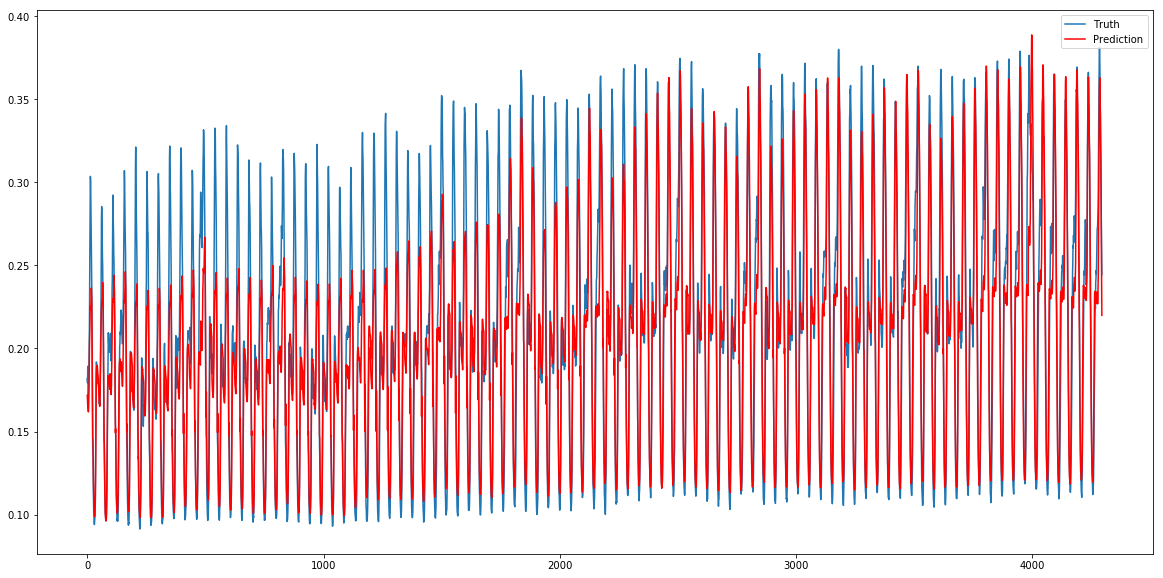

In [27]:
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [28]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAPE: 8.59 SMAPE: 4.40
